**Introduction**

I will train the ResNet18 neural network on a selection of MNIST data available at Google Colab using PyTorch. The model is complex enough to overfit the data. I decided to use data augmentation technique to improve the models performance.

I start with loading general python modules (numpy, panadas, pytorch) and my own module. My module is downloaded from github and saved in local directory. On Google Colab the file location is '/content/src/mnist.py'. It contains the code for my PyTorch implementation of the model, dataset and training loop. In the next section I will train the ResNet18 model.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import subprocess
import torch
import torchvision


In [2]:
overwrite=False
!mkdir -p ./src
!mkdir -p ./saved_models
src_directory=os.getcwd()+'/src'
src_file=src_directory+'/mnist.py'
if(overwrite): 
    subprocess.call(['wget','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/src/mnist.py','-O',str(src_file)])
else:
    subprocess.call(['wget','-nc','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/src/mnist.py','-O',str(src_file)])
sys.path.append(src_directory)
import mnist
%matplotlib inline

Training on device  cuda


In [3]:
train_data_path=os.getcwd()+'/sample_data/mnist_train_small.csv'
if not os.path.exists(train_data_path):
    print("Could not locate train data at %s."%train_data_path)
test_data_path=os.getcwd()+'/sample_data/mnist_test.csv'
if not os.path.exists(test_data_path):
    print("Could not locate test data at %s."%train_data_path)


In [4]:
test_data=mnist.MNISTdigits(test_data_path)

**Training ResNet18 model**

I will use the steepest gradient descent method with learning rate adjusted by hand (SGD optimizer). In each training step I train the model for 10 epochs (batch size 16). This is done when the function mnist.analyze_model(resnet,16,10) is called. Calling mnist.analyze_model(resnet,16,10) twice results in training the model for 20 epochs, etc. After each training step I plot the training loss value after each epoch.

In [ ]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio)

training time: 117.050074 	 train accuracy: 0.998625 	 valid accuracy: 0.987750 


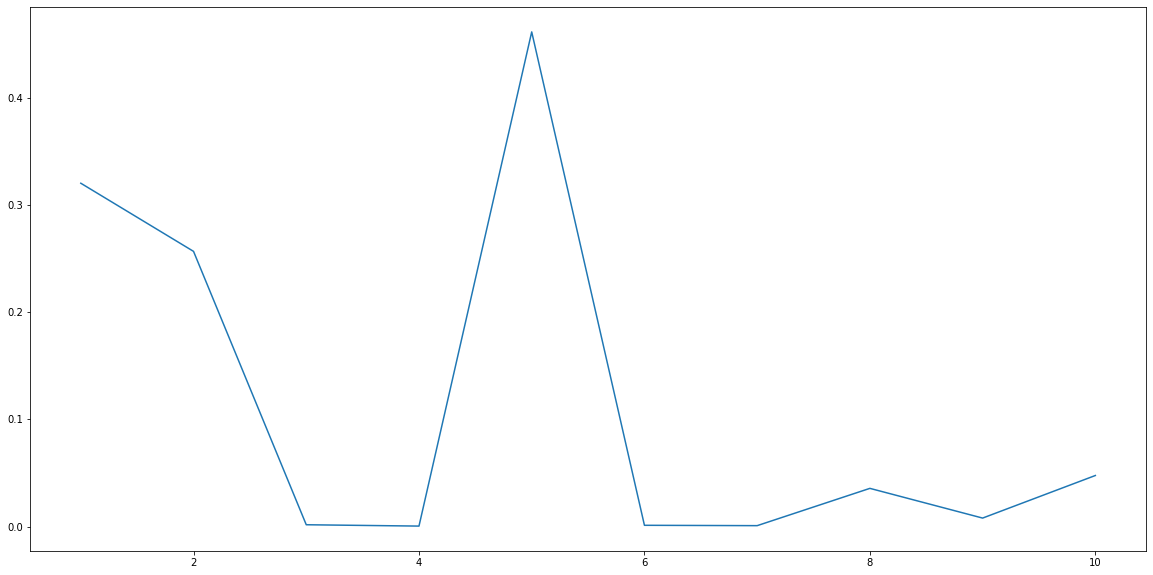

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 115.772001 	 train accuracy: 0.999813 	 valid accuracy: 0.987000 


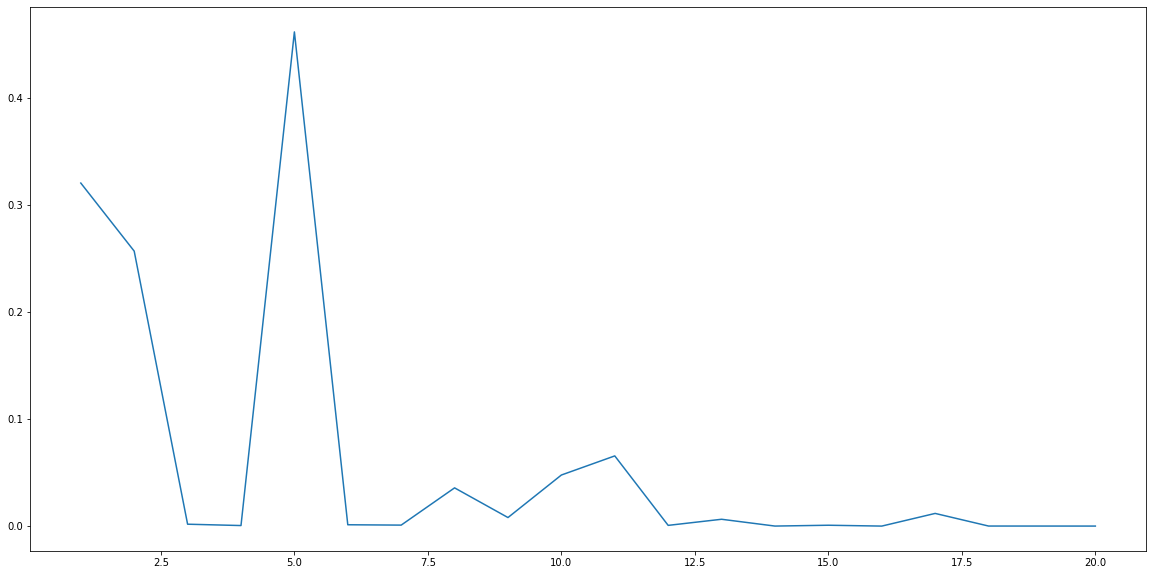

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 122.445497 	 train accuracy: 1.000000 	 valid accuracy: 0.988750 


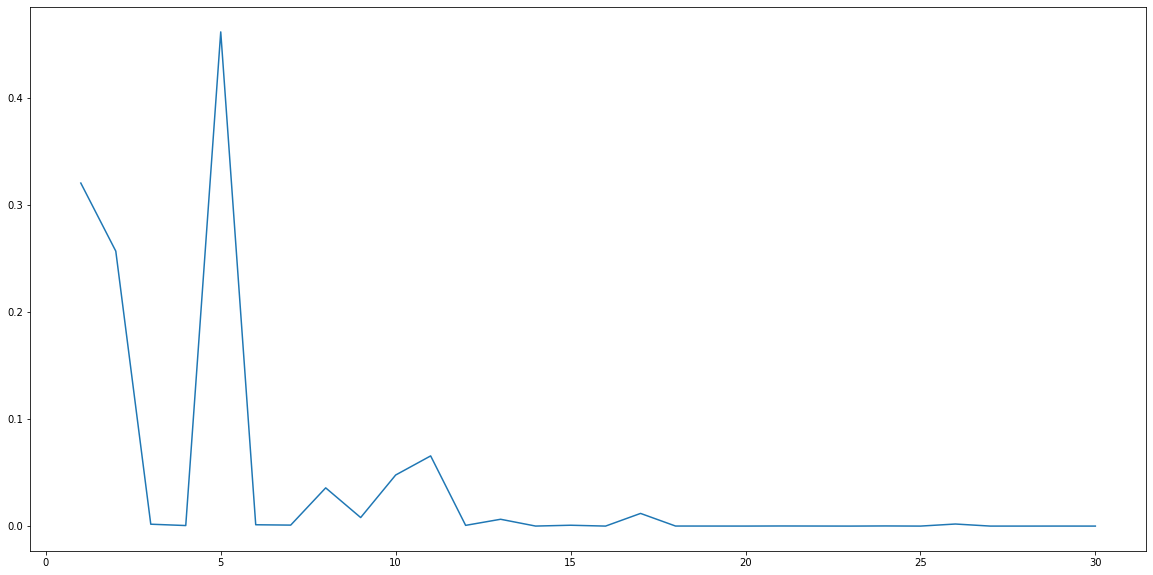

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 115.868394 	 train accuracy: 1.000000 	 valid accuracy: 0.990750 


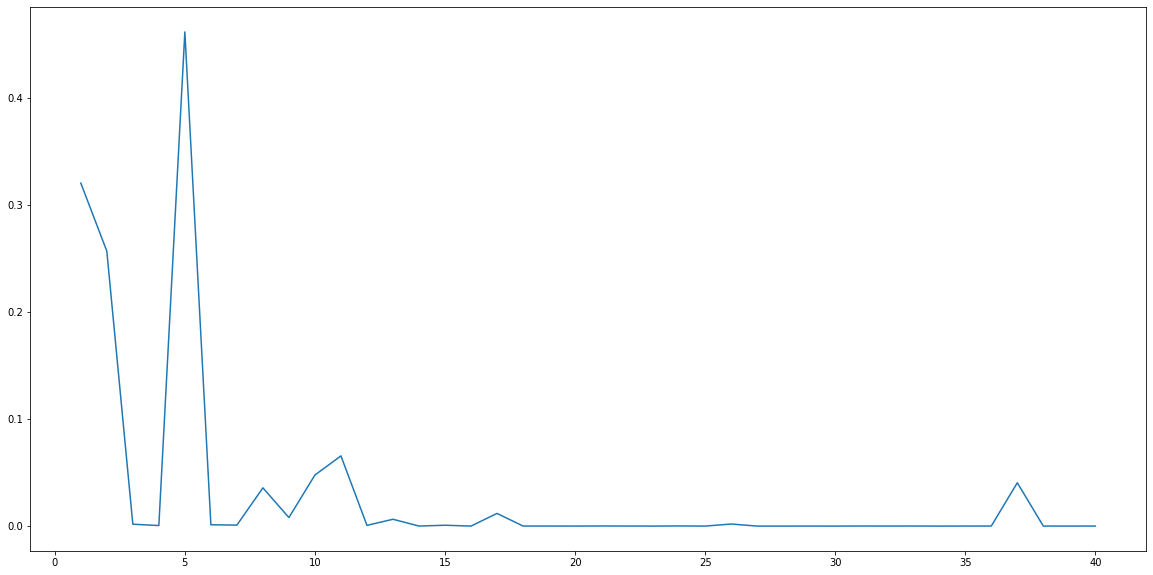

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

After 30 epochs the model overfits the data (train accuracy is 1.0) but the validation accuracy is highest when train accuracy is 1.0. This is a signal that we can do better by using more data. Generally, we would look for more training data when the train error is below our goal and the validation error is above our goal (see https://www.cs.cornell.edu/courses/cs4780/2021fa/lectures/lecturenote12.html for more details). Here the gap between the train accuracy and validation accuracy is very small but the results in Kaggle competition suggest that we can indeed do better. Instead of the small selection of data on google colab we could use the full data for example from torchvision.datasets.MNIST. For educational reasons (and having Kaggle competition in mind) I choose to create artificial data by applying random shear and rotation to the images in the small dataset. Let us measure the test accuracy and continue with testing different augmentation parameters.

In [ ]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.992400


**Data augmentation: rotation**

I will build twice bigger training dataset by creating artifical data. In order to create the artificial data I will apply transformations, which in this section are random rotations in the range of -10 to 10 degrees. This is done with resnet.load_data(train_data_path,split_ratio,2,transformation). The number 2 indicates that the augmented train set will be twice bigger that the original train set.

In [ ]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-10,10))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 277.205256 	 train accuracy: 0.998375 	 valid accuracy: 0.989500 


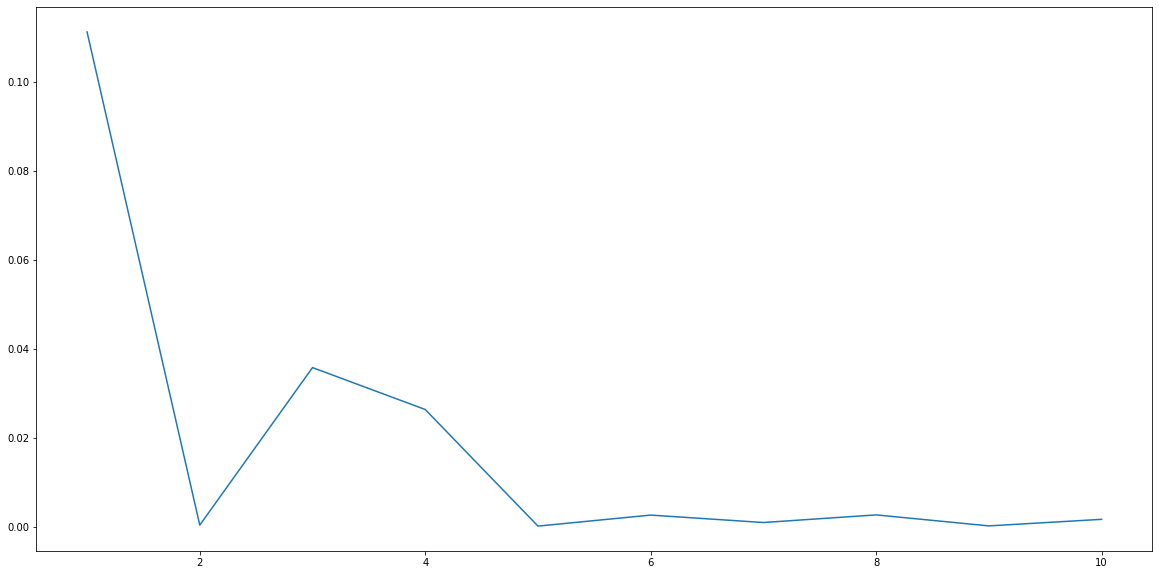

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 279.790690 	 train accuracy: 0.999656 	 valid accuracy: 0.990500 


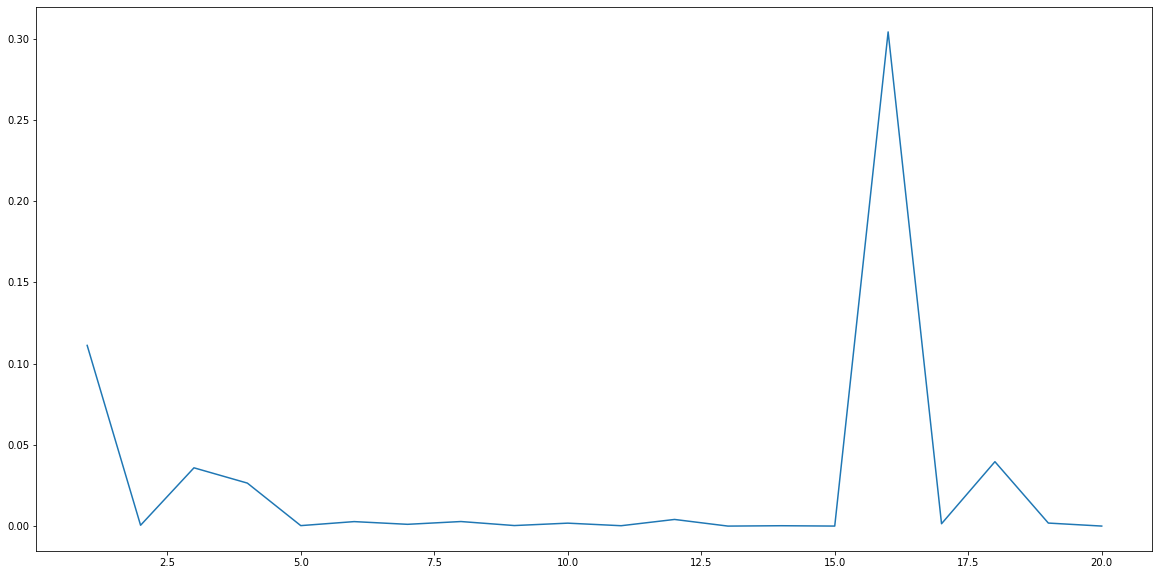

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 280.327545 	 train accuracy: 0.999656 	 valid accuracy: 0.990250 


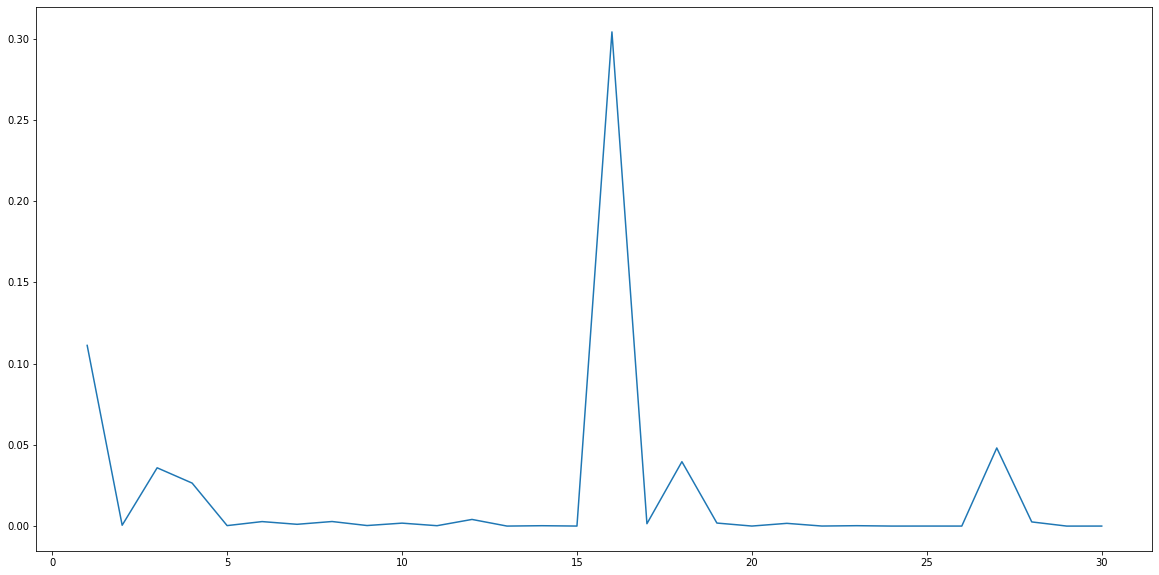

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 273.415339 	 train accuracy: 0.999938 	 valid accuracy: 0.991750 


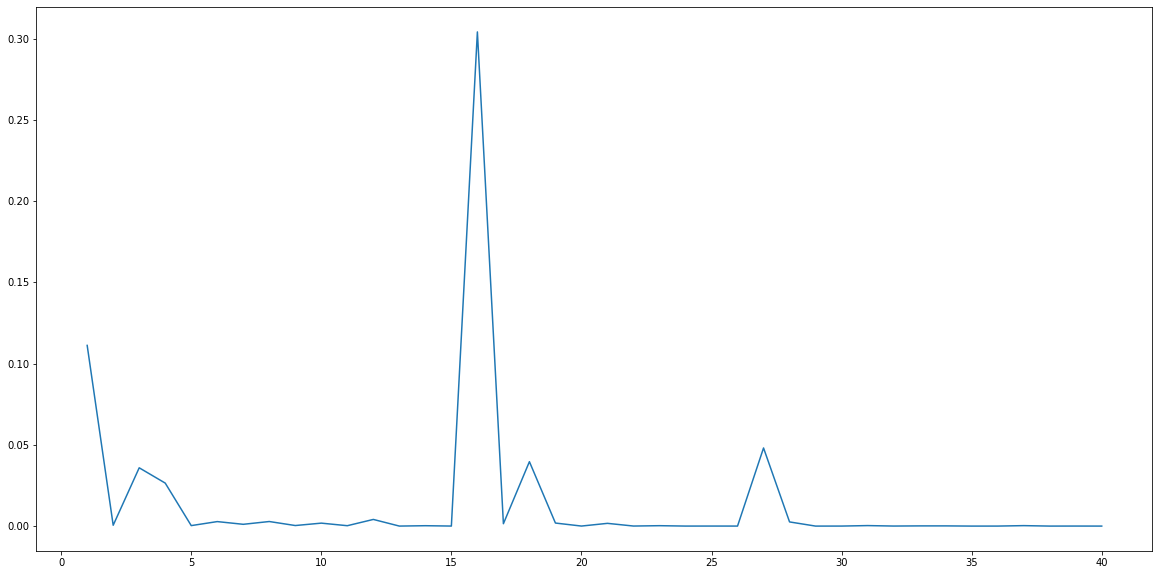

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 272.228525 	 train accuracy: 0.999813 	 valid accuracy: 0.990000 


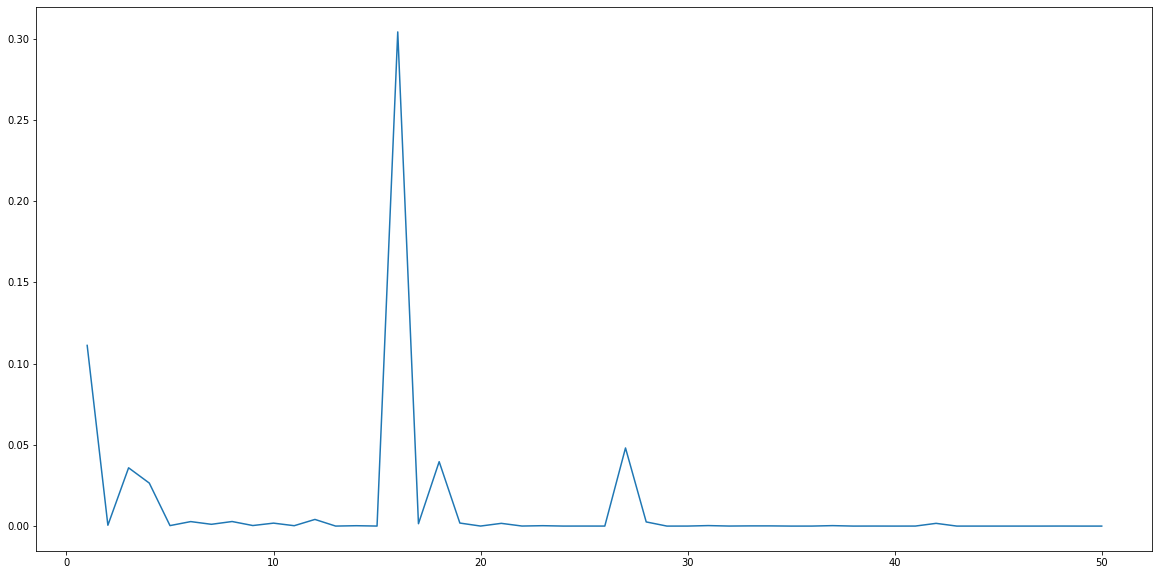

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 272.711227 	 train accuracy: 0.999781 	 valid accuracy: 0.989500 


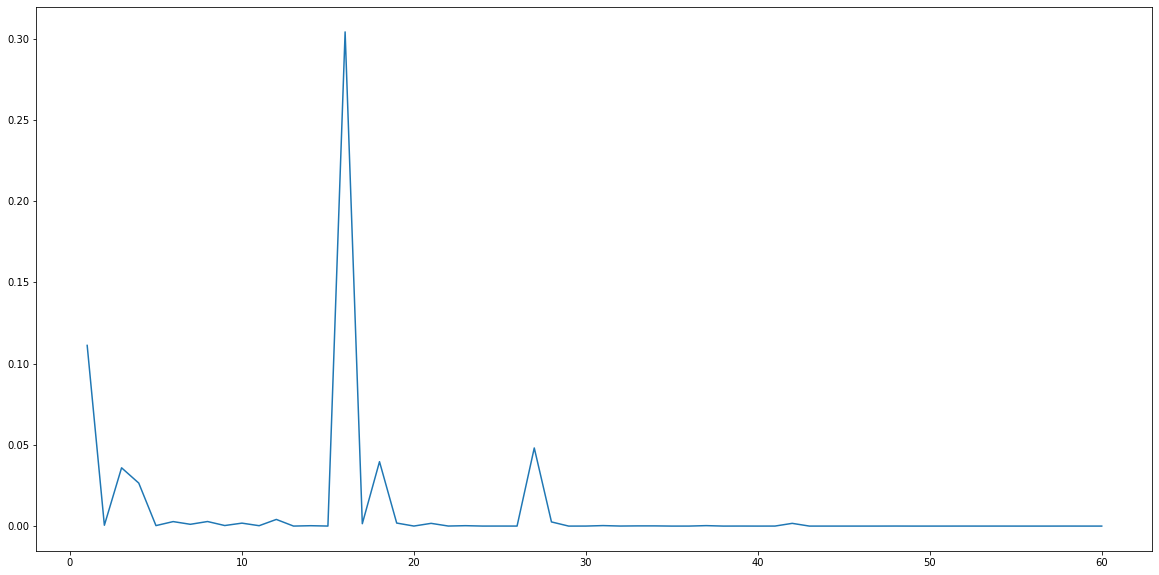

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 279.468709 	 train accuracy: 1.000000 	 valid accuracy: 0.991000 


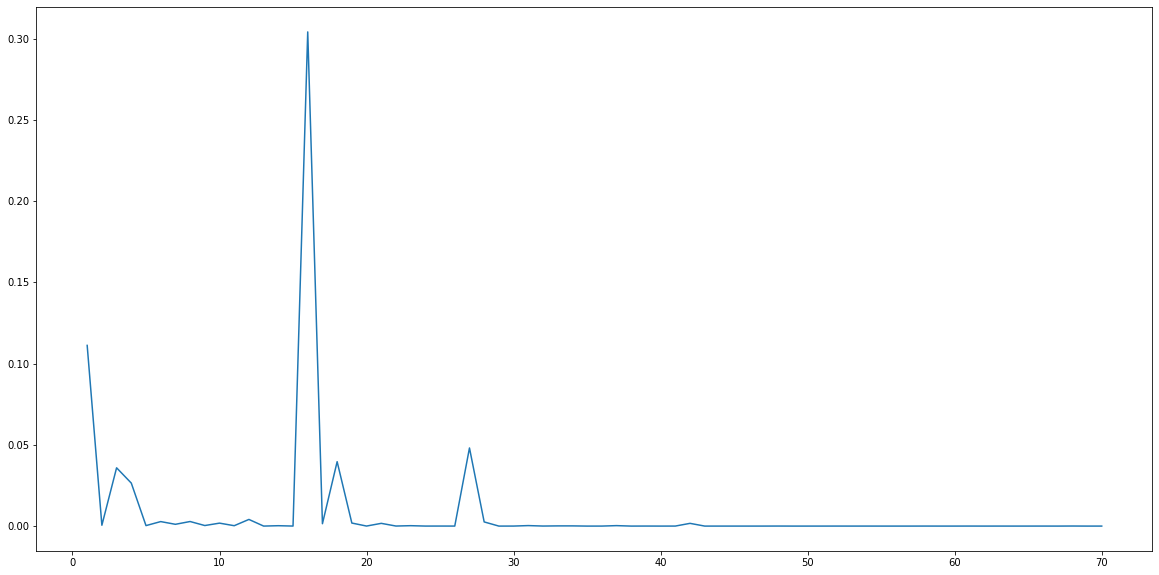

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.993500


**Data augmentation: shear**

In this section I will try another augmentation method: I will apply random shear.

In [ ]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=0,shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 287.091125 	 train accuracy: 0.998813 	 valid accuracy: 0.990500 


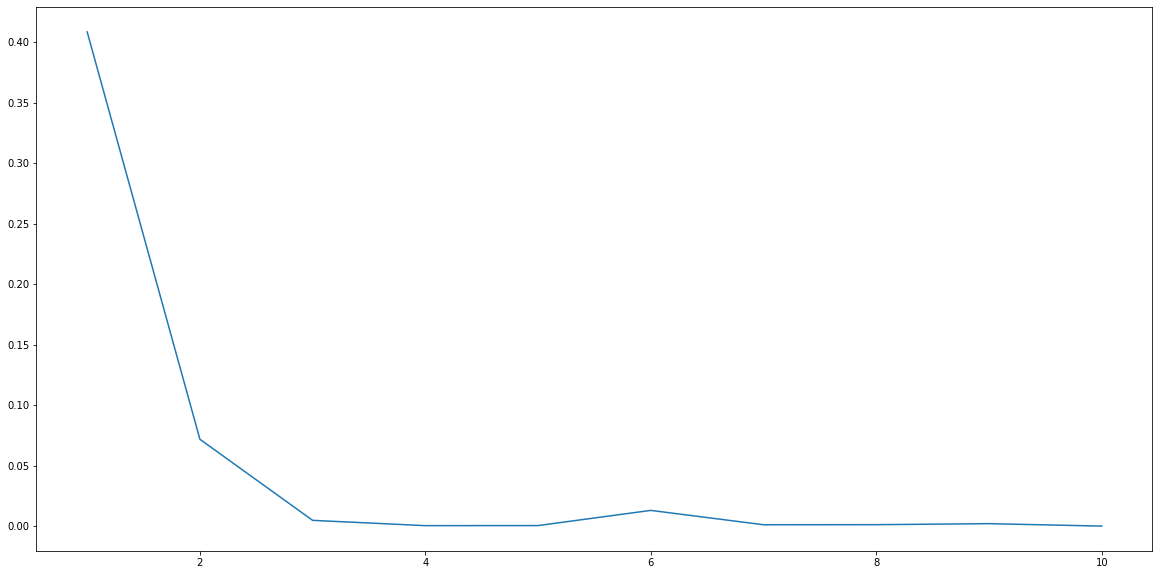

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 283.744947 	 train accuracy: 0.999250 	 valid accuracy: 0.988500 


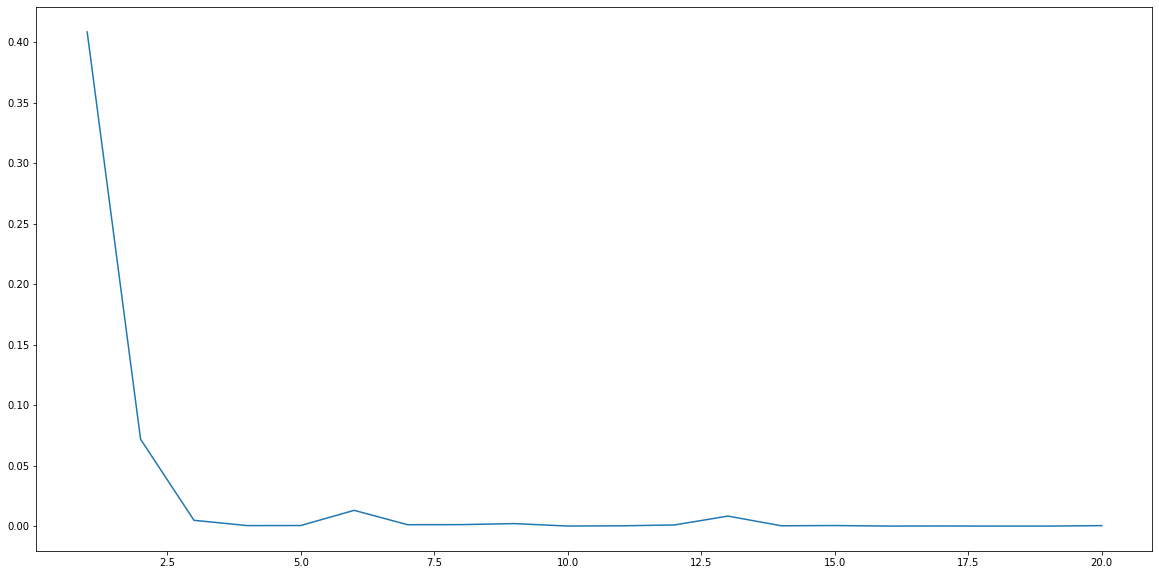

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 280.587507 	 train accuracy: 0.999313 	 valid accuracy: 0.989500 


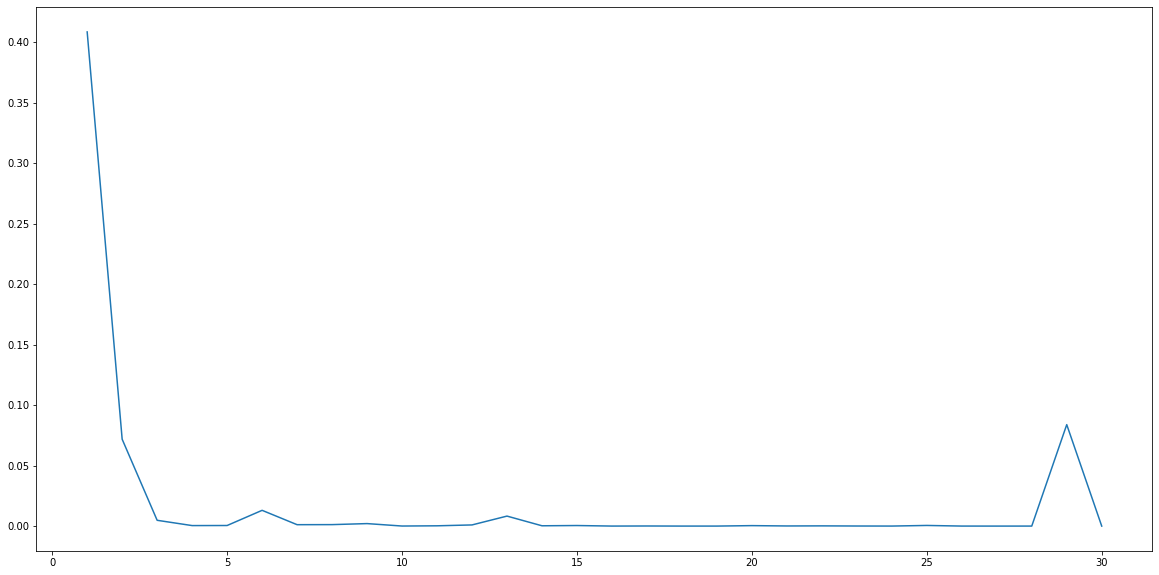

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 280.672483 	 train accuracy: 0.999844 	 valid accuracy: 0.991000 


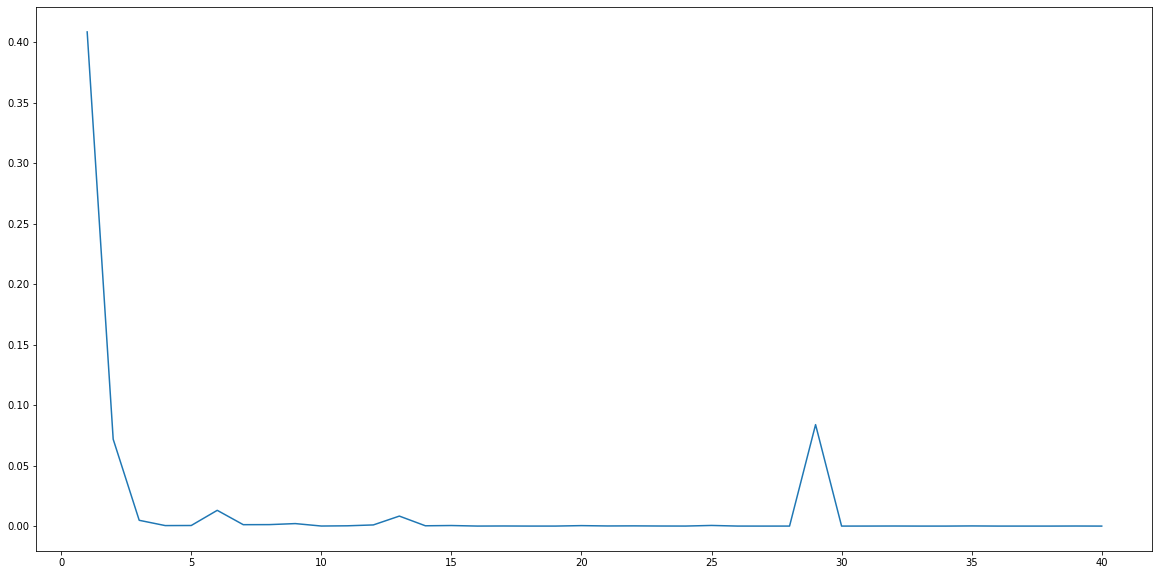

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 287.931114 	 train accuracy: 1.000000 	 valid accuracy: 0.991750 


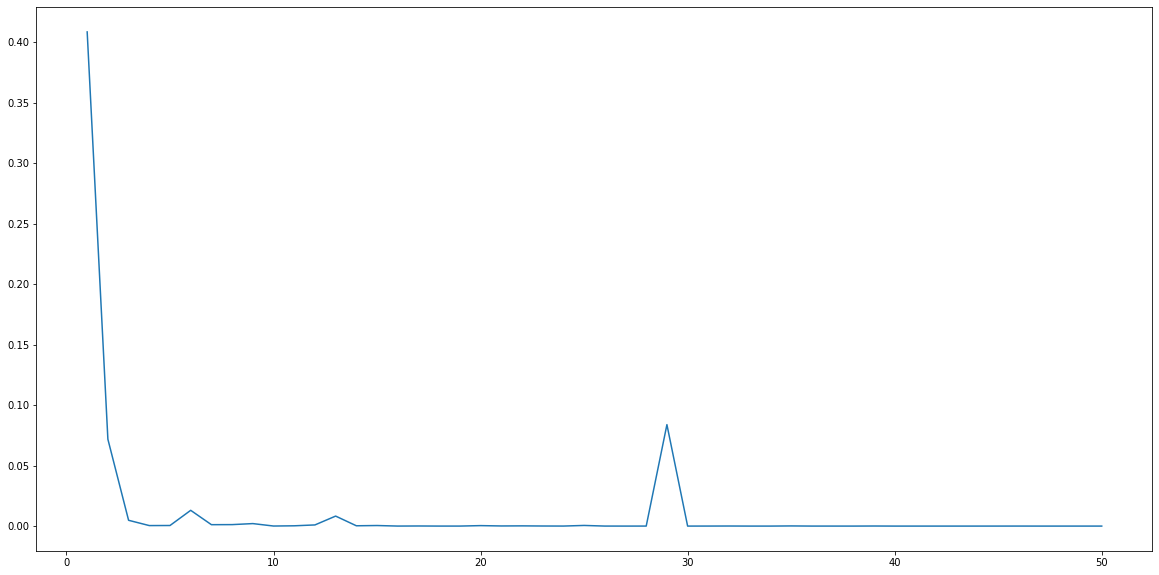

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.992800


**Data augmentation: shear + rotation**

In this section I will apply random rotations in the range of -10 to 10 degrees and random shears in the range of -15 to 15 degrees.

In [ ]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-10,10),shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 286.847177 	 train accuracy: 0.996594 	 valid accuracy: 0.987750 


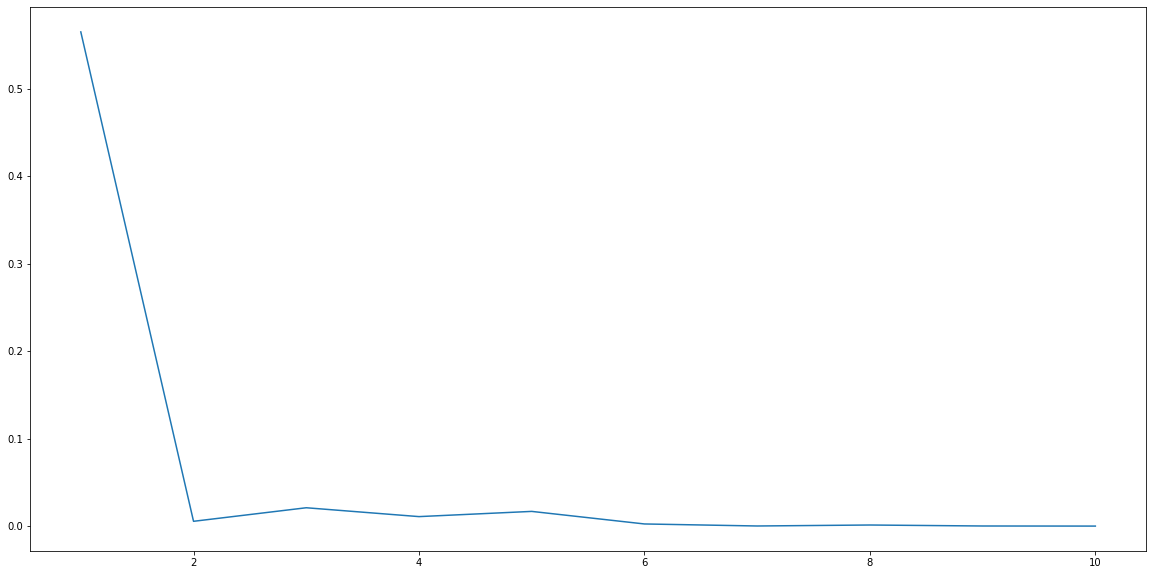

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 276.331762 	 train accuracy: 0.998406 	 valid accuracy: 0.990250 


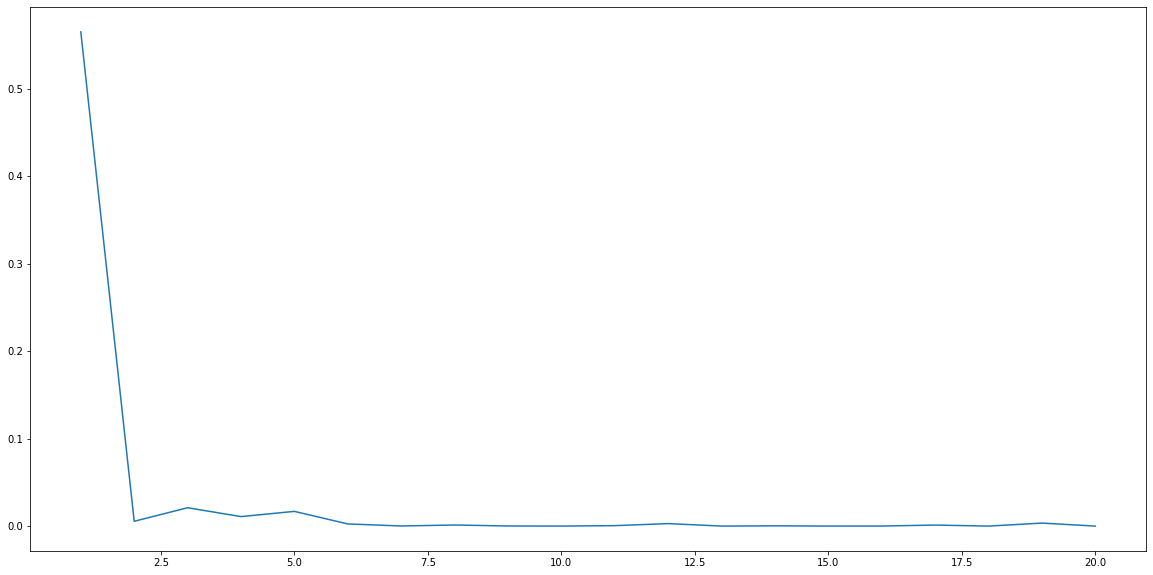

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 275.244609 	 train accuracy: 0.997625 	 valid accuracy: 0.986250 


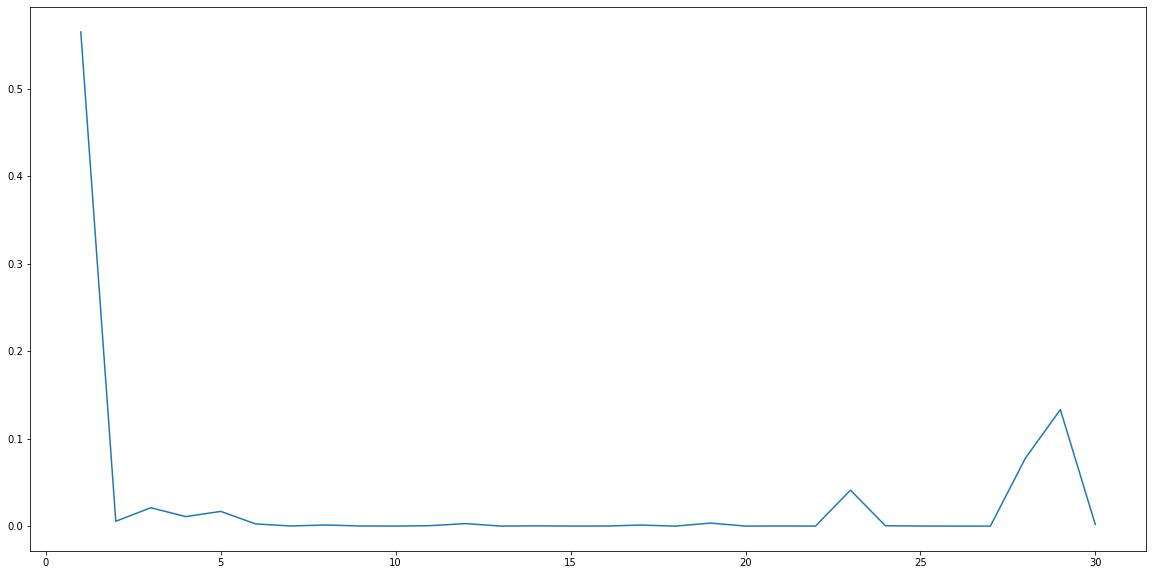

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 274.375859 	 train accuracy: 0.999188 	 valid accuracy: 0.991000 


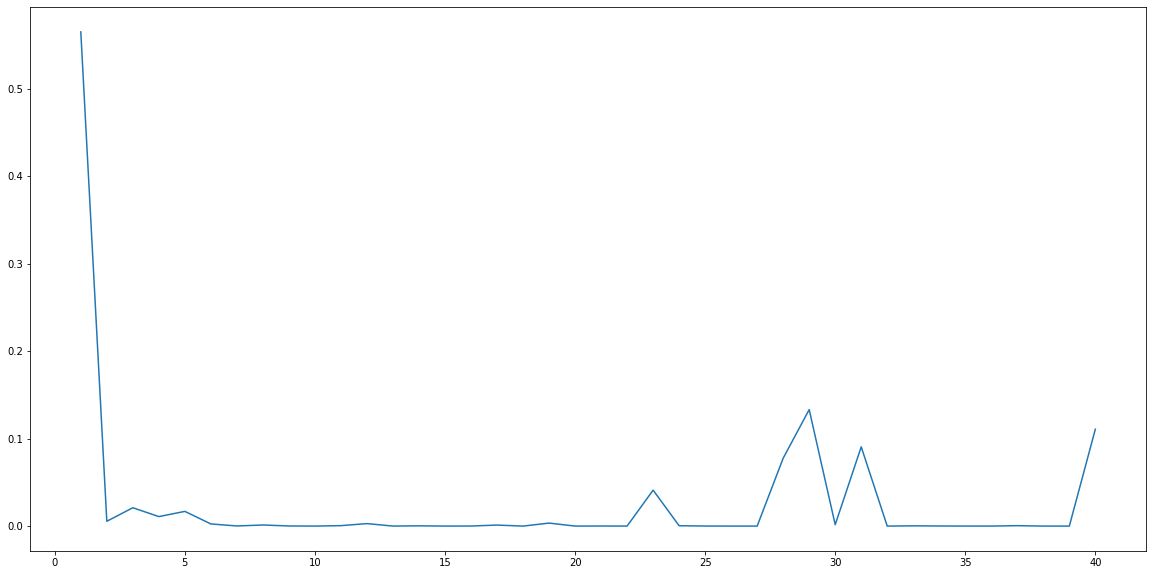

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 272.673023 	 train accuracy: 0.999875 	 valid accuracy: 0.993750 


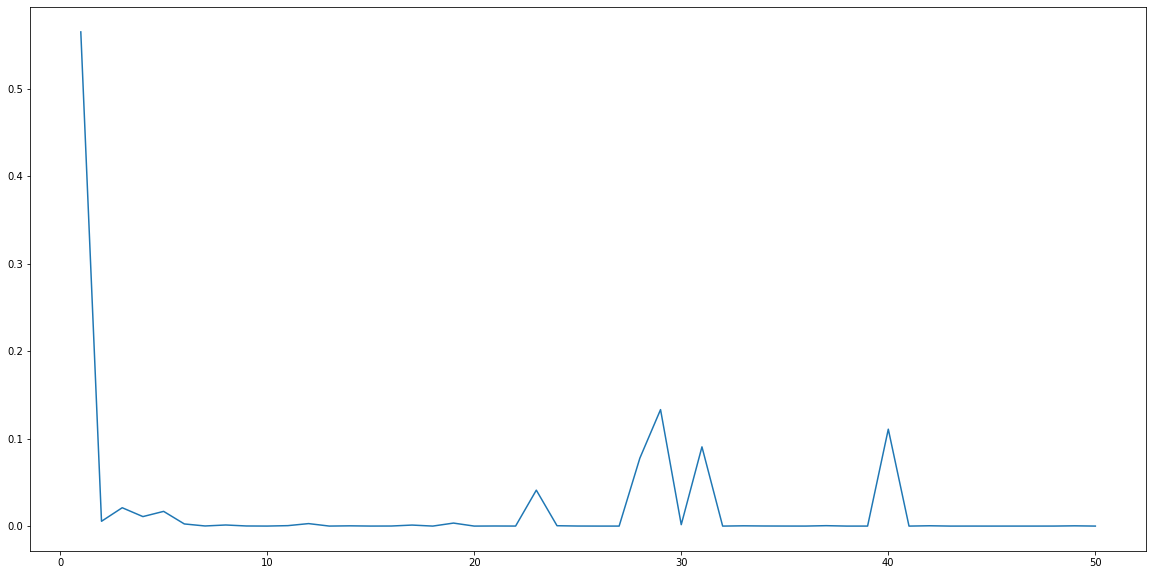

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 274.589915 	 train accuracy: 0.999906 	 valid accuracy: 0.994000 


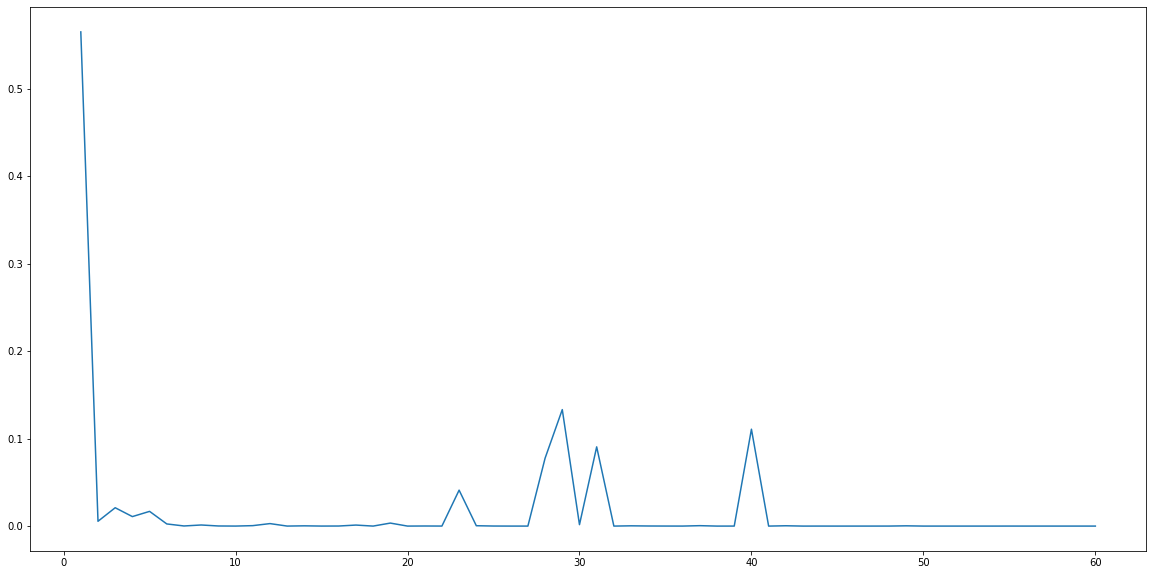

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 278.592720 	 train accuracy: 0.999906 	 valid accuracy: 0.993250 


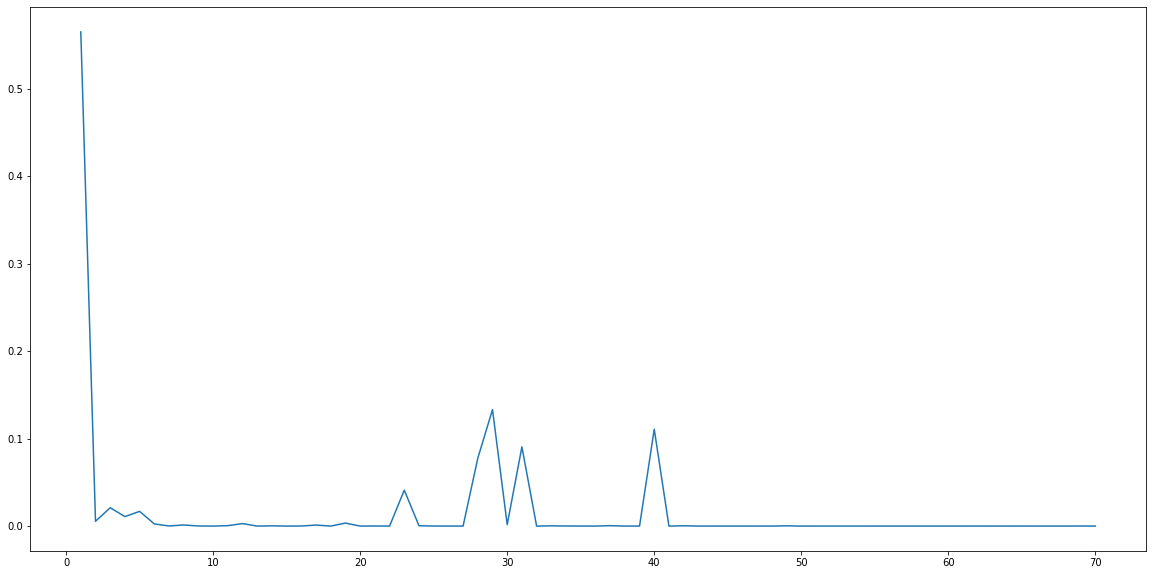

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 276.120561 	 train accuracy: 0.999875 	 valid accuracy: 0.993500 


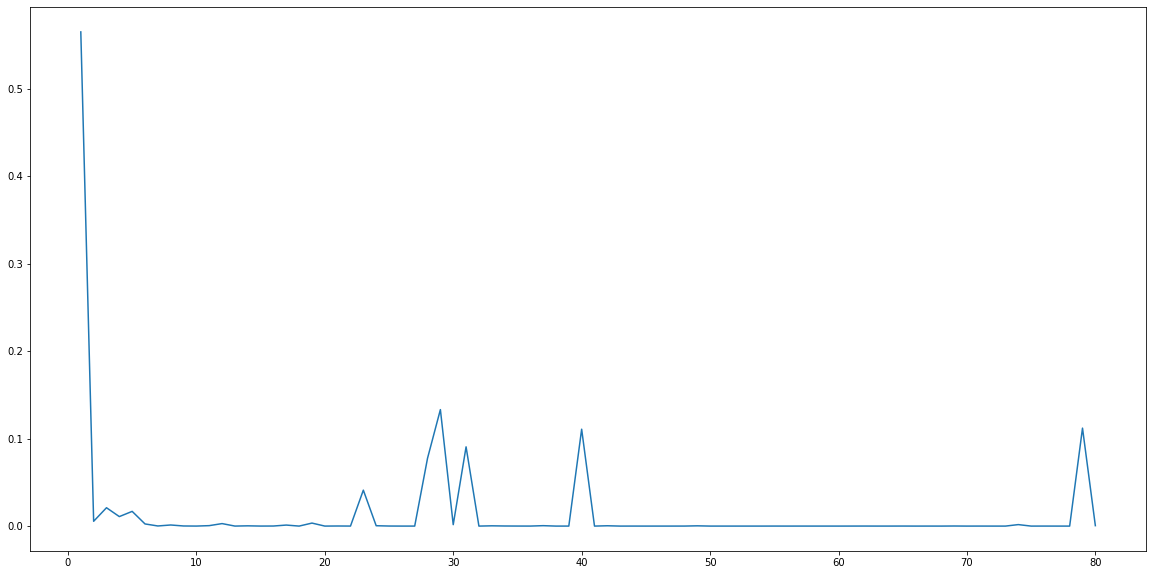

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 274.658696 	 train accuracy: 1.000000 	 valid accuracy: 0.993000 


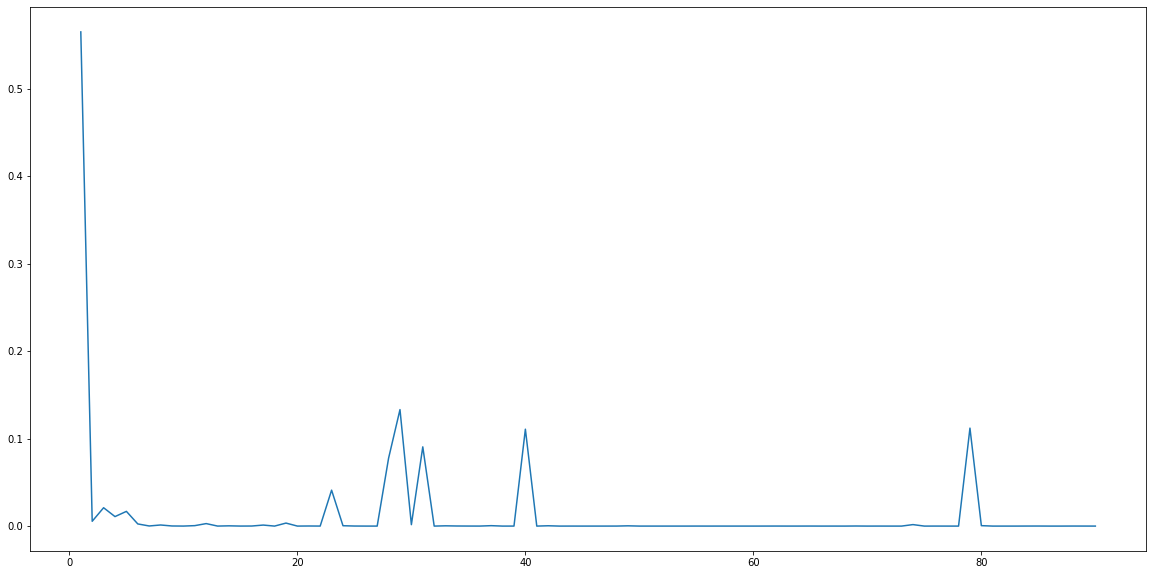

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.994200


**Data augmentation: different angles and shears**

I will check how increasing degrees range affects the models performance.

In [ ]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
augmentation_ratio=2
transform=torchvision.transforms.RandomAffine(degrees=(-30,30),shear=(-30,30))
resnet.load_data(train_data_path,split_ratio,augmentation_ratio,transform)

training time: 302.038940 	 train accuracy: 0.991969 	 valid accuracy: 0.988500 


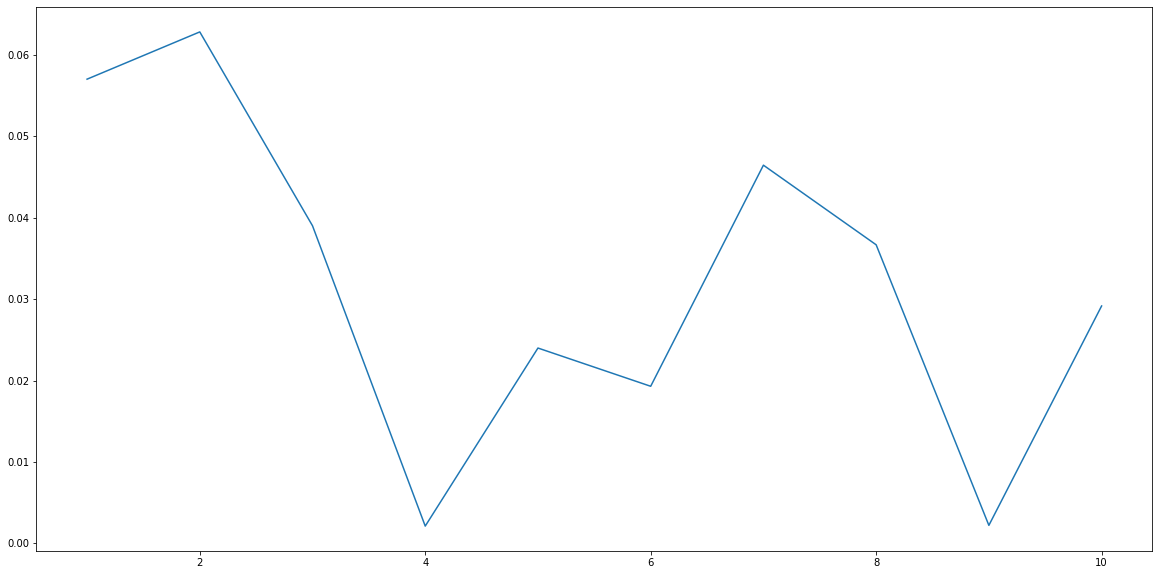

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 296.871774 	 train accuracy: 0.995406 	 valid accuracy: 0.990250 


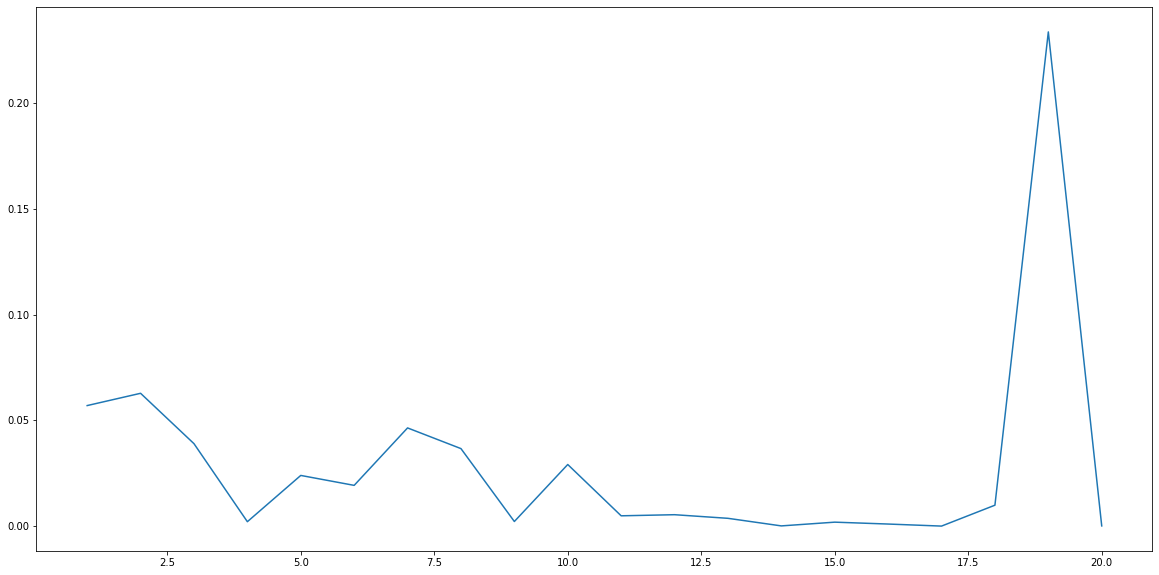

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 297.423838 	 train accuracy: 0.997188 	 valid accuracy: 0.991250 


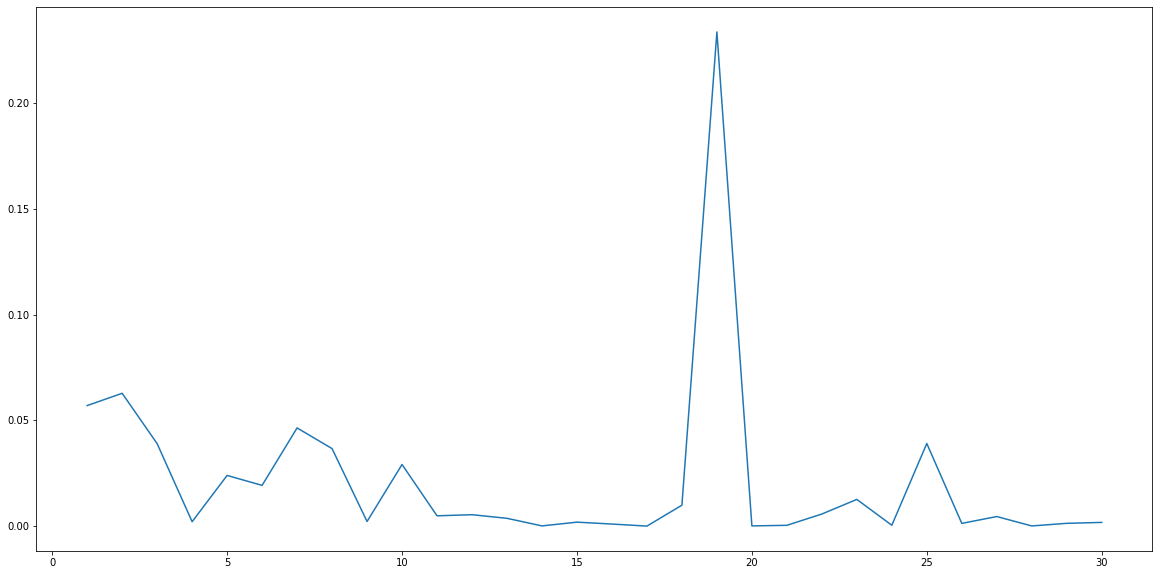

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 890.952462 	 train accuracy: 0.997406 	 valid accuracy: 0.988500 


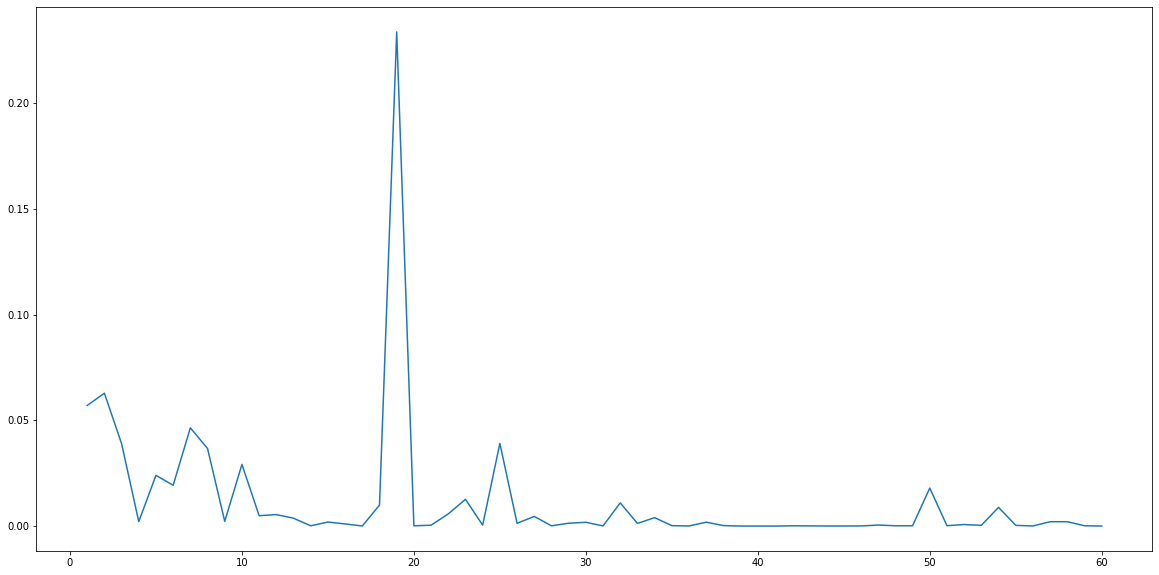

In [ ]:
results=mnist.analyze_model(resnet,16,30)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 293.886004 	 train accuracy: 0.999281 	 valid accuracy: 0.991250 


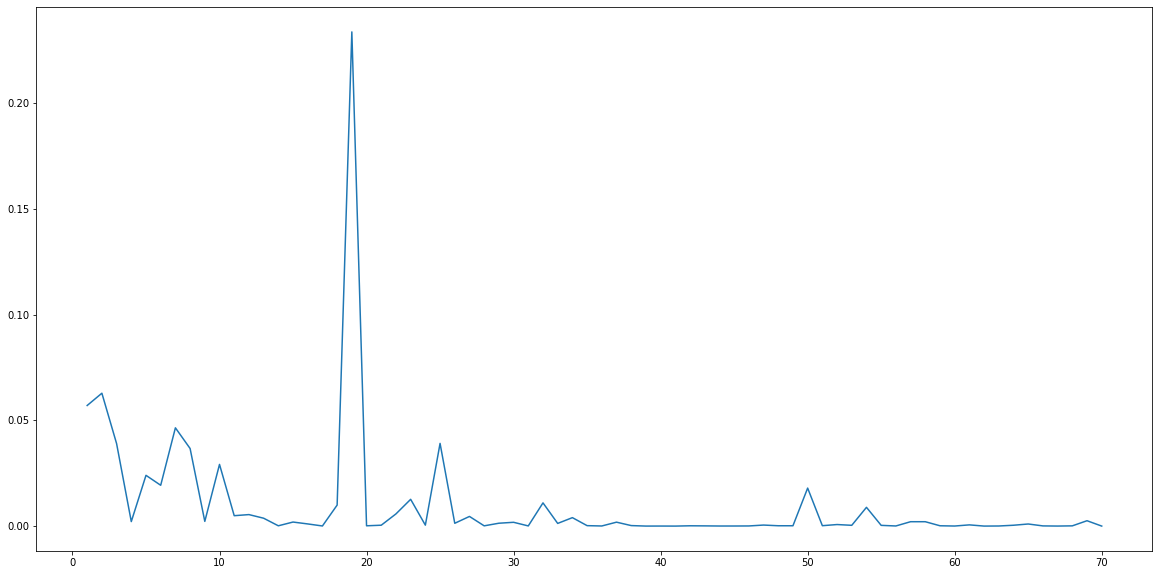

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 288.474112 	 train accuracy: 0.999531 	 valid accuracy: 0.992000 


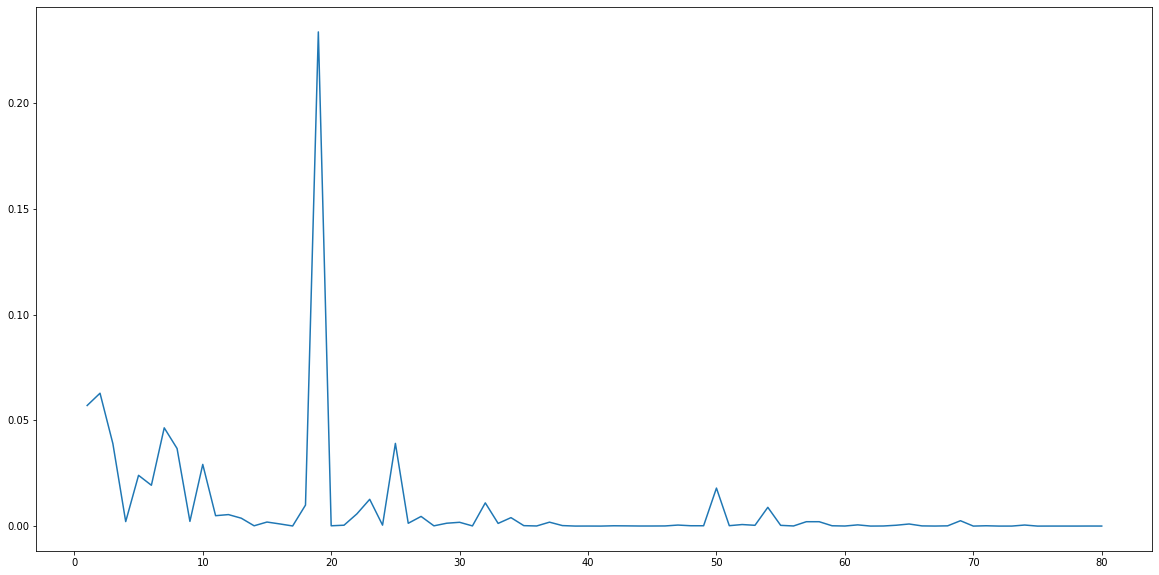

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 288.340569 	 train accuracy: 0.999750 	 valid accuracy: 0.992000 


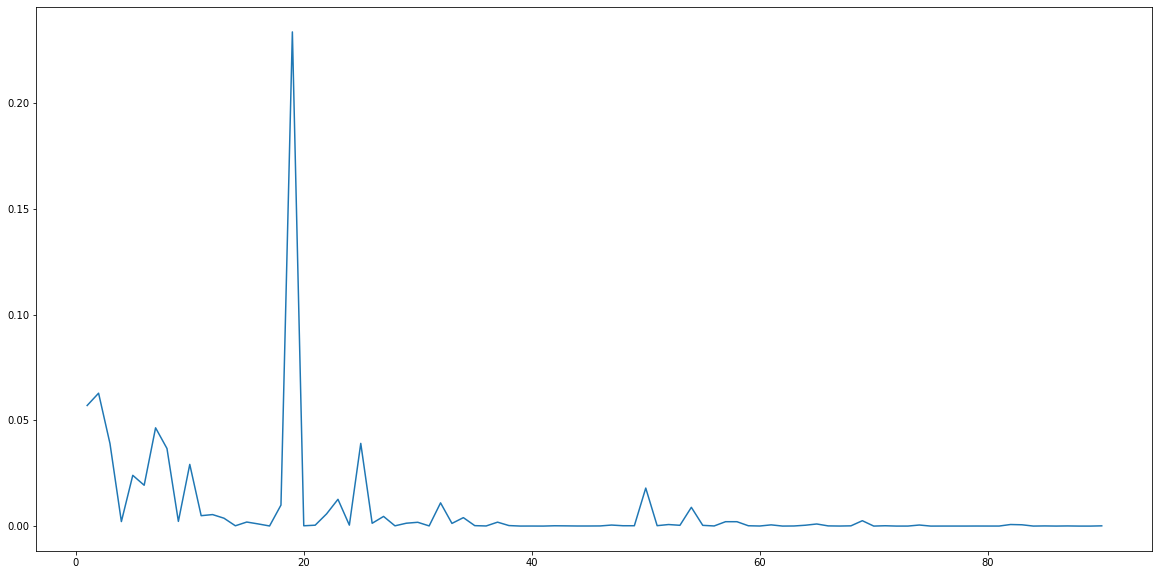

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.993700


In [ ]:
resnet.save_parameters("_augmentation_ratio_%d_rotation_30_shear_30"%augmentation_ratio)

**Bigger augmentation**

In [5]:
learning_rate=1.0e-01
augmentation_ratio=10
resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-10,10),shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,augmentation_ratio,transformation)

training time: 1561.228744 	 train accuracy: 0.999794 	 valid accuracy: 0.991500 


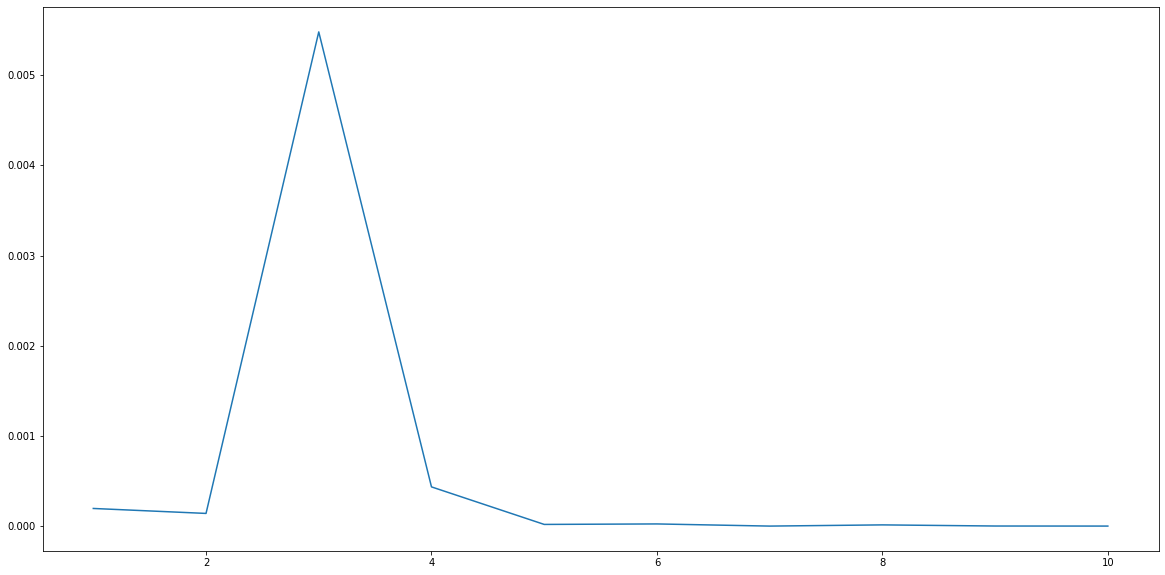

In [6]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 1550.645615 	 train accuracy: 0.999694 	 valid accuracy: 0.991500 


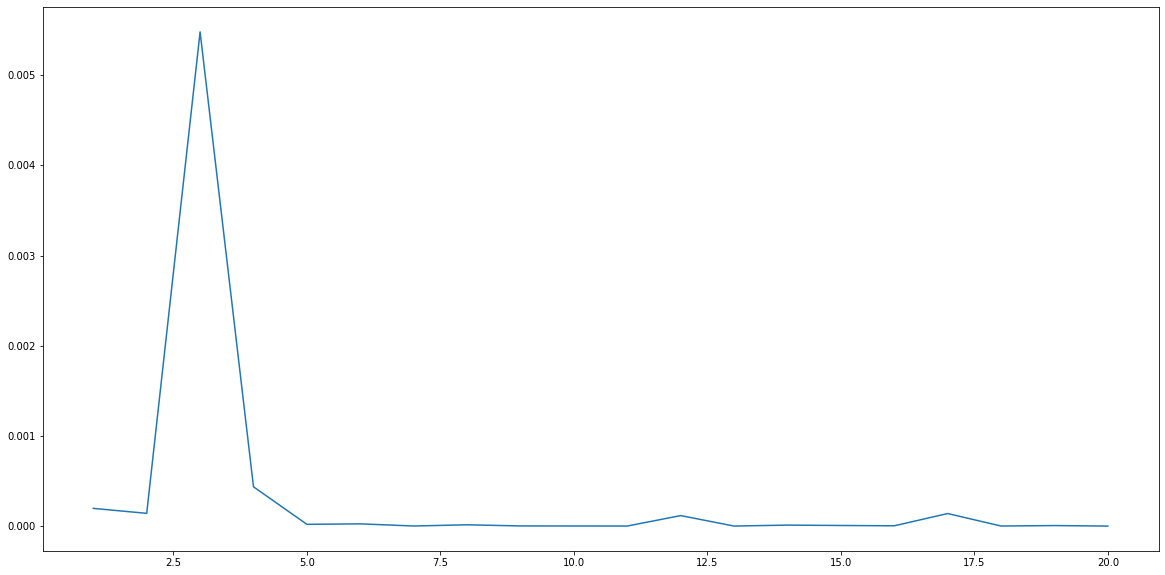

In [7]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 1558.350464 	 train accuracy: 0.999987 	 valid accuracy: 0.992500 


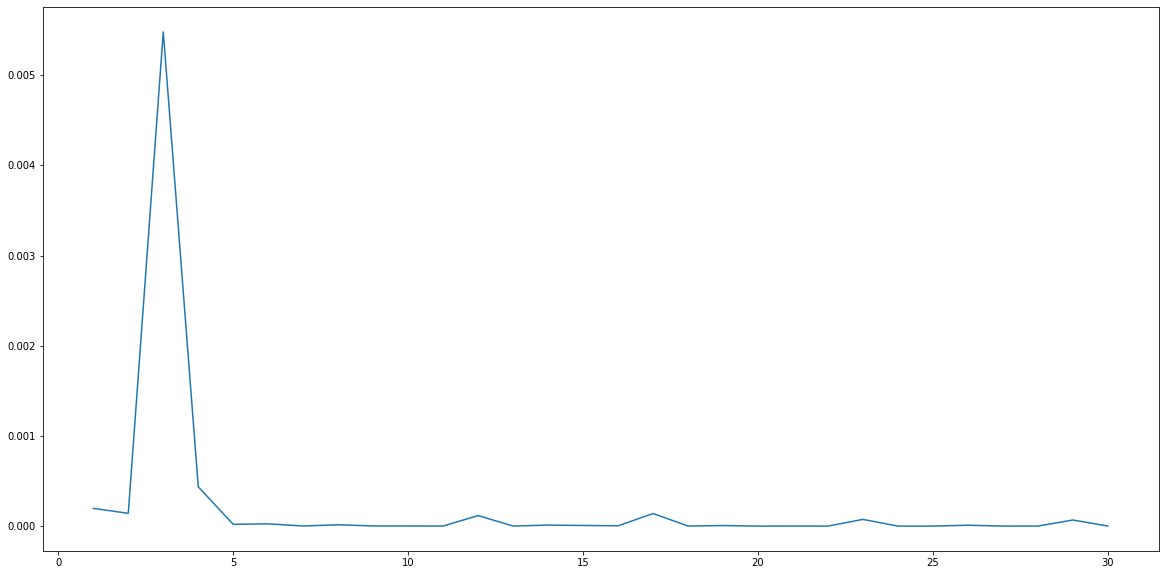

In [8]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 1556.237934 	 train accuracy: 0.999987 	 valid accuracy: 0.991750 


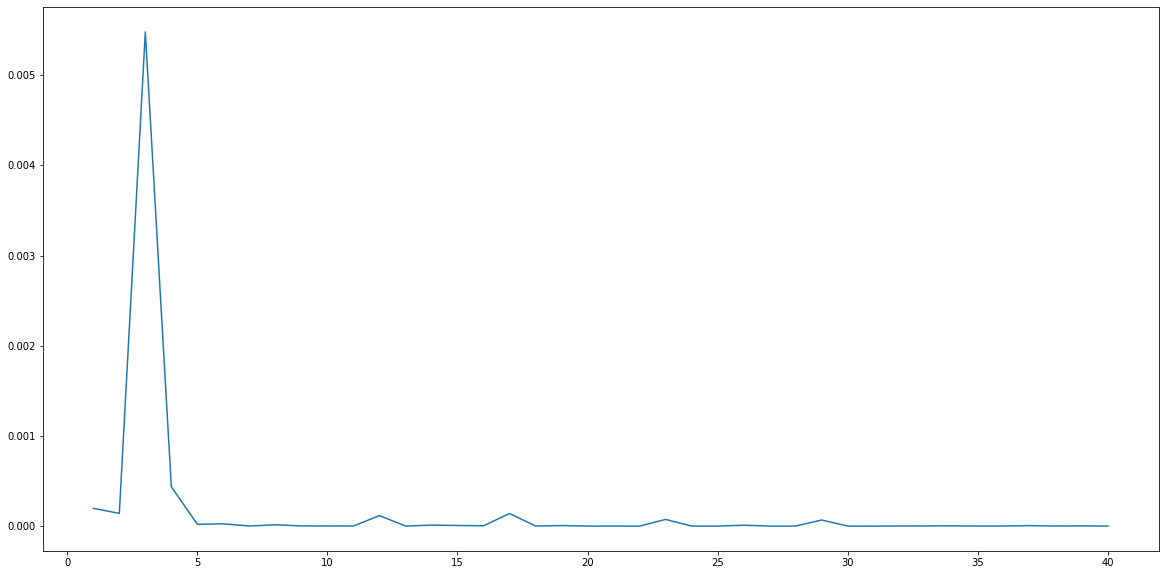

In [9]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 1553.719265 	 train accuracy: 1.000000 	 valid accuracy: 0.991750 


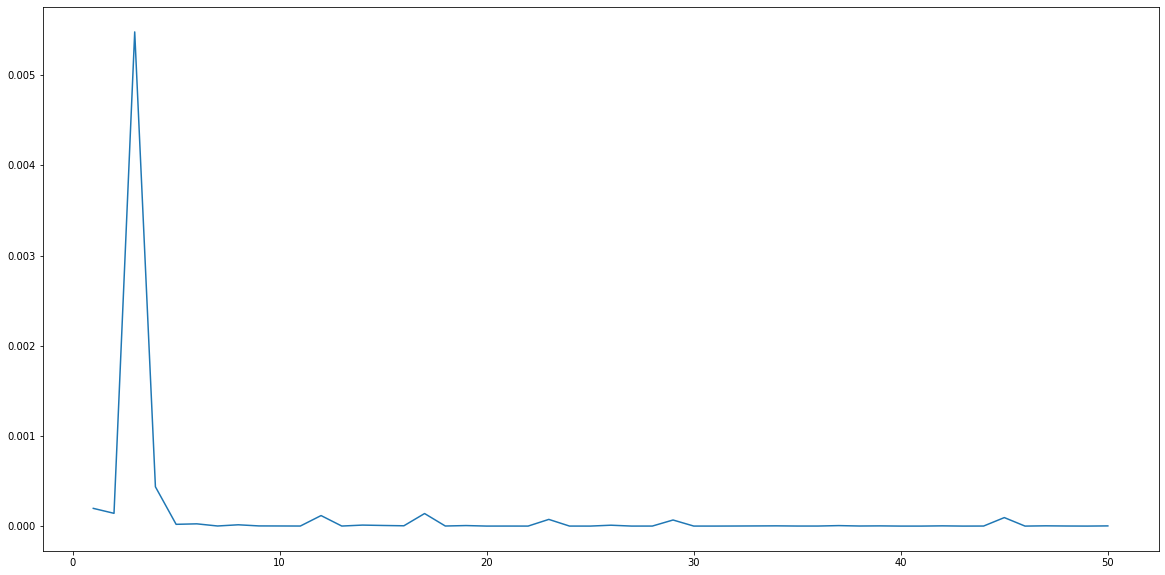

In [10]:
learning_rate=1.0e-03
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
learning_rate=1.0e-03
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [11]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.994500


In [ ]:
resnet.save_parameters("_augmentation_ratio_%d_rotation_15_shear_15"%augmentation_ratio)

By looking at the validation results we conclude that data augmentation leads to an improvement in our model. Let us underline that we make the decision which model to use basing on train and validation scores. The test scores are for educational reasons and debugging. The test scores are close to validation scores so there the validation set is chosen properly, in particular it is representative and there is no data leakage. 